In [1]:
from snowflake.nodes import *
from snowflake.stencil_compiler import CCompiler
from snowflake_openmp.compiler import TiledOpenMPCompiler
import numpy as np
from scipy import misc
%pylab inline
!ctree -cc

Populating the interactive namespace from numpy and matplotlib
ctree looking for relative cache directories named compiled, checking directories under this one



`%matplotlib` prevents importing * from pylab and numpy


In [2]:
l = np.tile(misc.lena(), (2, 2))

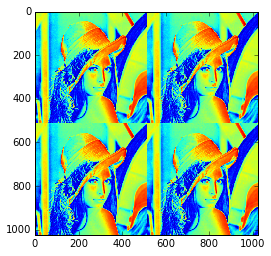

In [3]:
plt.imshow(l)
plt.show()

In [4]:
print(l.shape)
print(l.nbytes)
print(l.dtype)

(1024, 1024)
8388608
int64


In [6]:
sobel_x_component = StencilComponent('arr', WeightArray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
sobel_y_component = StencilComponent('arr', WeightArray([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
print(hash(sobel_x_component))

-7160376217278679681


In [7]:
sobel_x = Stencil(sobel_x_component * sobel_x_component, 'out', ((1, -1, 1), (1, -1, 1)))
sobel_y = Stencil(sobel_y_component * sobel_y_component, 'out', ((1, -1, 1), (1, -1, 1)))
sobel_total = Stencil(sobel_x_component * sobel_x_component + sobel_y_component * sobel_y_component, 'out', ((1, -1, 1), (1, -1, 1)))

In [8]:
compiler = TiledOpenMPCompiler()
compiler2 = CCompiler()

In [9]:
sobel_omp = compiler.compile(sobel_total)
sobel_c = compiler2.compile(sobel_total)

In [10]:
lena_x = np.empty(l.shape, l.dtype)

In [11]:
lena_out = np.zeros_like(l)
sobel_omp(lena_out, l)
sobel_c(lena_out, l)

In [20]:
sobel_omp.arg_spec

('out', 'arr')

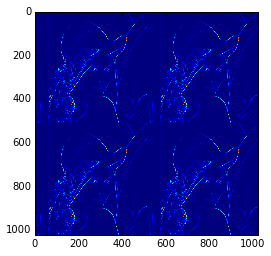

In [15]:

plt.imshow(lena_out)
plt.show()

In [13]:
# threshold = np.sqrt(np.average(final**2))
# threshold

In [14]:
# plt.imshow(final > threshold, cmap='gray')
# plt.show()
# plt.imshow(final2 > threshold, cmap='gray')

In [16]:
import cProfile

In [17]:
cProfile.run('sobel_omp(lena_out, l)')

         112 function calls (111 primitive calls) in 0.003 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.003    0.003 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <string>:8(__new__)
        1    0.000    0.000    0.000    0.000 ConfigParser.py:367(getboolean)
        2    0.000    0.000    0.000    0.000 ConfigParser.py:373(optionxform)
        2    0.000    0.000    0.000    0.000 ConfigParser.py:567(__init__)
        2    0.000    0.000    0.000    0.000 ConfigParser.py:570(__getitem__)
        2    0.000    0.000    0.000    0.000 ConfigParser.py:590(get)
        2    0.000    0.000    0.000    0.000 ConfigParser.py:657(_interpolate)
        4    0.000    0.000    0.000    0.000 __init__.py:1155(info)
        4    0.000    0.000    0.000    0.000 __init__.py:1344(getEffectiveLevel)
        4    0.000    0.000    0.000    0.000 __init__.py:1358(isEnabledFor)
      

In [18]:
import time

In [19]:
ITERATIONS = 1000
t = time.time()
for i in range(ITERATIONS):
    sobel_omp(lena_out, l)
print('Tiled OMP', (time.time() - t)/ITERATIONS)
t = time.time()
for i in range(ITERATIONS):
    sobel_c(lena_out, l)
print('C', (time.time() - t)/ITERATIONS)

('Tiled OMP', 0.001639948844909668)
('C', 0.0023880648612976075)


In [22]:
from ctree.frontend import dump
print(dump(sobel_total))

Stencil(op_tree=StencilOp(left=StencilOp(left=StencilComponent(name='arr', weights=WeightArray(weights=[
    StencilConstant(value=-1),
    StencilConstant(value=0),
    StencilConstant(value=1),
    StencilConstant(value=-2),
    StencilConstant(value=0),
    StencilConstant(value=2),
    StencilConstant(value=-1),
    StencilConstant(value=0),
    StencilConstant(value=1),
  ])), right=StencilComponent(name='arr', weights=WeightArray(weights=[
    StencilConstant(value=-1),
    StencilConstant(value=0),
    StencilConstant(value=1),
    StencilConstant(value=-2),
    StencilConstant(value=0),
    StencilConstant(value=2),
    StencilConstant(value=-1),
    StencilConstant(value=0),
    StencilConstant(value=1),
  ]))), right=StencilOp(left=StencilComponent(name='arr', weights=WeightArray(weights=[
    StencilConstant(value=-1),
    StencilConstant(value=-2),
    StencilConstant(value=-1),
    StencilConstant(value=0),
    StencilConstant(value=0),
    StencilConstant(value=0),
    St